# part 2

### Loading the model and analysis from part 1

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv('./data/laptopData.csv')

# Rename the column 'Unnamed: 0' to 'ID'
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Define the adjusted exchange rate based on a specific example
price_in_pkr_example = 47895.5232  # Example price in PKR
target_price_usd = 1000  # Desired average price in USD
adjusted_exchange_rate = price_in_pkr_example / target_price_usd

# Convert the 'Price' column to USD and replace the original column
data['Price'] = data['Price'] / adjusted_exchange_rate

# Create a copy of the original DataFrame
copy_data = data.copy()

# Remove rows with NaN values in the 'Price' column
copy_data = copy_data[~copy_data['Price'].isna()]

# Display rows number
print("Number of rows in the original DataFrame:", copy_data.shape[0])

#display data types of each column
print("Data types:" )
print(copy_data.dtypes)

# Display the first few rows of the modified DataFrame
copy_data.head()

Number of rows in the original DataFrame: 1273
Data types:
ID                  float64
Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object


,ID,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1490.299686
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,1000.000000
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,639.642245
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2822.713418
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,2006.363050


## preproccing

In [2]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()
model_data = copy_data.copy()

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = model_data.select_dtypes(include=[np.number])
print("Encoded columns done.")

Encoded columns done.


## Basic Model Pipeline 

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Feature selection and target variable
X = model_data.drop(columns=['Price'])
y = model_data['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
    
# Make predictions
y_pred = model.predict(X_test)

print("Model training complete.")

Model training complete.


## Results of the basic pipeline

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}k")
print(f"MAE: {mae:.2f}k")
print(f"R2 Score: {r2:.3f}")


Model Performance Metrics:
RMSE: 313.30k
MAE: 193.69k
R2 Score: 0.845


# Error Analysis
After running the basic model, we will analyze its errors to identify areas for improvement.

### A. Predicted vs Actual Price


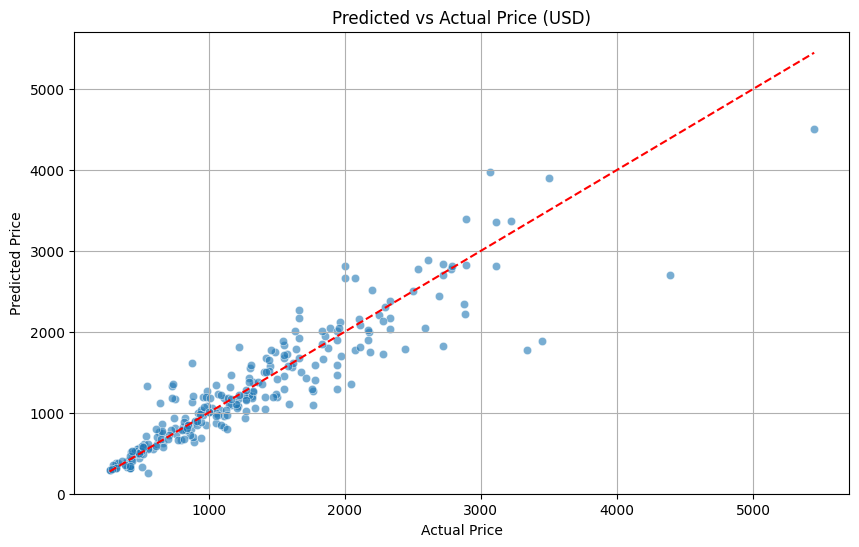

In [5]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Price (USD)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

### B. Error Distribution

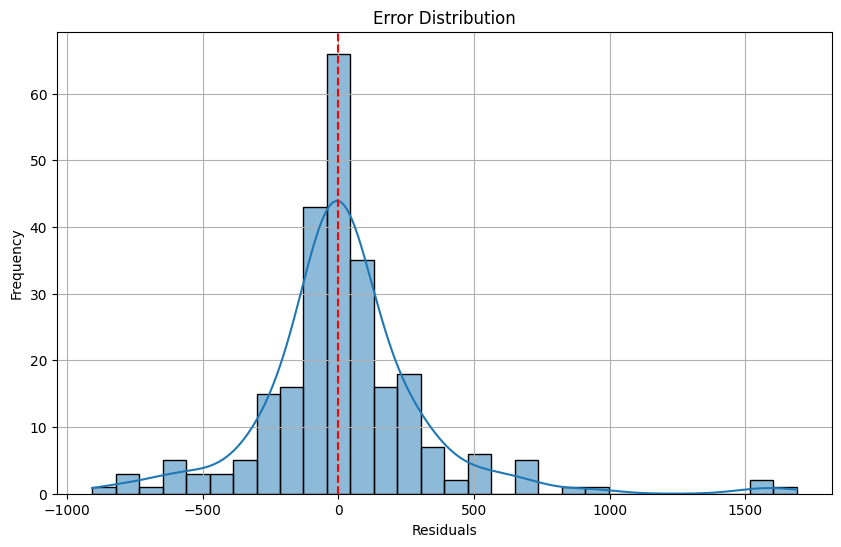

In [6]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual (Perfect Prediction)')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### C. Features Importance

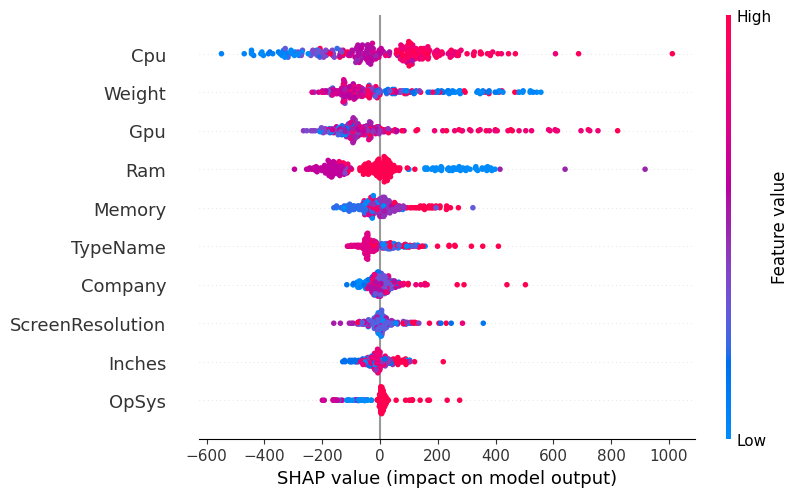

In [7]:
import shap

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot SHAP beeswarm plot
shap.plots.beeswarm(shap_values)

### D. Overestimations and Underestimations by Price

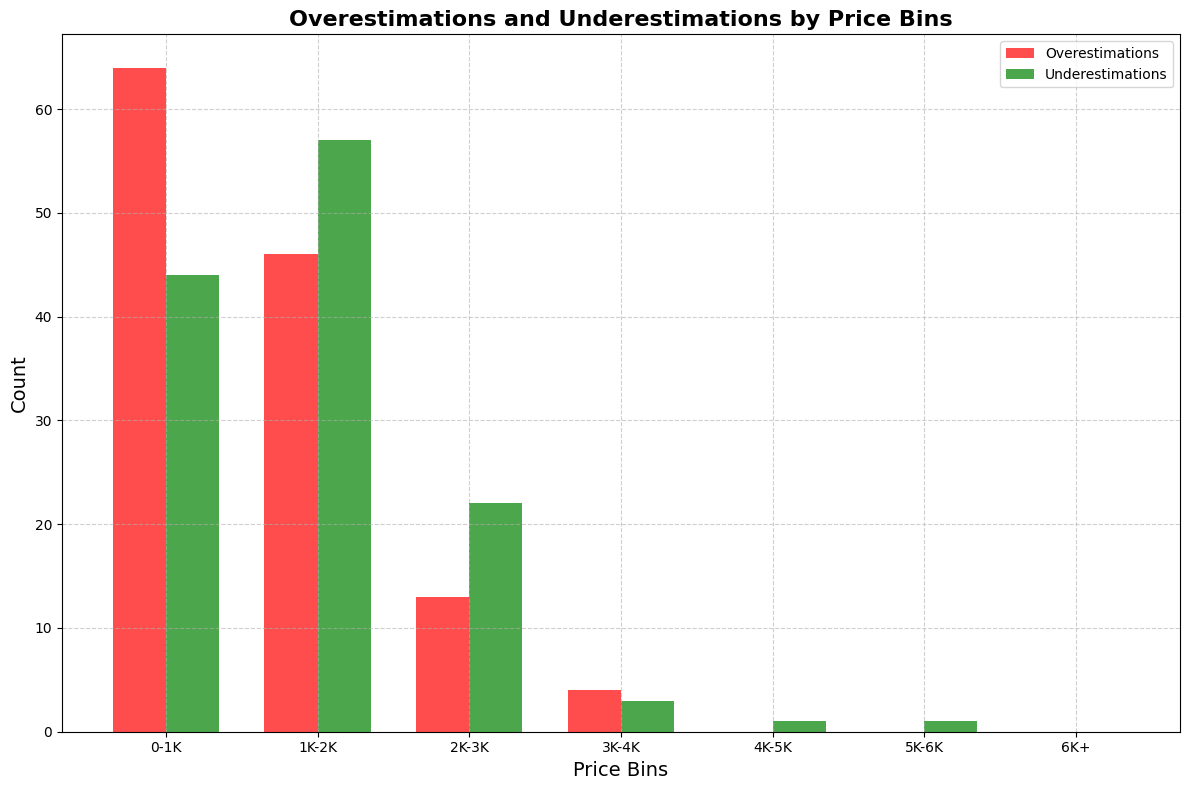

In [8]:

# Define bins for price ranges
price_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
price_labels = ['0-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K', '5K-6K', '6K+']
y_test_binned = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Residual': residuals,
    'Price Range': y_test_binned
})

# Calculate overestimations and underestimations by price range
over_under_estimations = analysis_df.groupby('Price Range').apply(
    lambda group: pd.Series({
        'Overestimations': (group['Residual'] < 0).sum(),
        'Underestimations': (group['Residual'] > 0).sum()
    })
).reset_index()

# Plot overestimations and underestimations by price range
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(over_under_estimations))

plt.bar(index, over_under_estimations['Overestimations'], bar_width, label='Overestimations', color='red', alpha=0.7)
plt.bar(index + bar_width, over_under_estimations['Underestimations'], bar_width, label='Underestimations', color='green', alpha=0.7)

plt.ylabel('Count', fontsize=14)
plt.xlabel('Price Bins', fontsize=14)
plt.title('Overestimations and Underestimations by Price Bins', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, over_under_estimations['Price Range'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### After loading the model and analysis from part 1 let's start part 2
<hr>

# Error Analysis Conclusions & work plan

### **Error Analysis Conclusions:**
1. **Predicted vs. Actual Price**
   - The scatterplot of predicted vs. actual prices shows that the model performs well for most cases, with data points closely following the diagonal red line.
   - However, outliers, where the predicted prices deviate significantly from the actual values, indicate specific cases where the model fails. These may arise due to insufficient representation of certain price ranges or inadequate feature engineering.

2. **Error Distribution**
   - The residuals are mostly centered around zero, indicating the model performs reasonably well. However, outliers in both positive and negative residuals highlight cases where the model struggles to make accurate predictions.
   - Outliers on both positive and negative ends highlight specific cases where the model struggles to generalize, possibly due to edge cases or insufficient representation of certain data points in the training set.

3. **SHAP Value Analysis**
   - Features like **CPU**, **RAM**, and **GPU** have strong predictive power but show high variability in their contributions. This variability might reflect complex, non-linear interactions that the model struggles to fully capture.
   - Minimal impact from features like **Operating System** and **Screen Resolution** suggests they might not contribute significantly to the model's accuracy and could be revisited or transformed for better representation.

4. **Overestimations and Underestimations by Price Range**
   - Most overestimations occur in the lower price ranges (0-1K USD), which could indicate the model struggles to capture the nuances of cheaper laptops.
   - Underestimations are prevalent in the mid-price range (1K-3K USD), suggesting that the model underestimates the value of mid-tier laptops, potentially due to feature interactions or insufficient data diversity.


### **What Might Have Caused the Errors**

1. **Inefficient Features:**
   - Redundant or irrelevant features, such as `Weight` and `TypeName`, may have introduced noise, diluting the influence of more meaningful predictors.
   - These unnecessary features can lead to overfitting, increased model variance, and poorer generalization to unseen data.

2. **Presence of Outliers:**
   - Outliers in critical features may disproportionately affect the model's training process, leading to skewed predictions.
   - Extreme values can dominate the optimization process, reducing the model's ability to learn the underlying patterns across the majority of the data.

3. **Lack of Normalization:**
   - Features with varying scales may result in unequal contributions to the model during training.
   - This imbalance may cause the model to prioritize larger numerical features while ignoring smaller-scaled yet significant ones.

4. **Overly Simple Features:**
   - The absence of engineered features that capture complex interactions may cause the model to overlook critical nonlinear relationships.
   - Simple, raw features may fail to adequately represent nuanced dependencies, limiting the model's predictive accuracy.

5. **Missing Values:**
   - Missing values in important features if not handled properly can result in incomplete or biased datasets.


### **Work Plan for Error Reduction**

**1. Inefficient Features**
   - **Optional Solution:** Perform feature selection and engineering to identify and retain only meaningful predictors while removing redundant or irrelevant ones.
   - **Why:** Eliminating inefficient features reduces noise in the dataset, improves the model's focus on influential variables, and minimizes overfitting by lowering dimensionality.

**2. Presence of Outliers**
   - **Optional Solution:** Detect and handle outliers using methods like interquartile range (IQR), Z-scores, or advanced techniques such as Isolation Forests.
   - **Why:** Removing or capping outliers ensures that extreme values do not dominate the model's learning process, allowing it to generalize better across the dataset.

**3. Lack of Normalization**
   - **Optional Solution:** Apply consistent scaling techniques like `StandardScaler` or `MinMaxScaler` across all numerical features.
   - **Why:** Normalization ensures that all features contribute equally to the model, preventing bias toward features with larger numerical ranges and improving gradient-based optimization processes.

**4. Overly Simple Features**
   - **Optional Solution:** Engineer complex interaction features.
   - **Why:** Advanced feature engineering captures nonlinear relationships and subtle dependencies in the data, improving the model's ability to learn nuanced patterns.

**5. Missing Values**
   - **Optional Solution:** Use appropriate imputation techniques, such as median imputation for numerical data or most-frequent imputation for categorical data, while analyzing patterns in the missing data.
   - **Why:** Properly handling missing values prevents biases introduced by incomplete data and ensures the integrity of the training set.

**6. Hyperparameter Tuning**
   - Plan systematic optimization of the XGBoost model parameters, such as learning rate, depth, and number of estimators, using `GridSearchCV`, `RandomizedSearchCV`, or Bayesian optimization methods.
   - **Why:** Fine-tuning hyperparameters ensures the model is optimized for its structure and dataset, improving performance and preventing overfitting.




By addressing these issues systematically, the model can achieve improved accuracy, generalization, and robustness while reducing noise and biases from the dataset.

# Improving Model Performance


## preproccing

**Identifying and Addressing Weaknesses**

For missing values weakness, I used the **most frequent imputation** to address missing values, which could bias the model and hinder learning. This method ensures consistency by filling gaps with the most common values, preserving the dataset's structure and statistical integrity. This approach improved data quality, enabling the model to train effectively and generalize better.

In [9]:
from sklearn.impute import SimpleImputer

# Convert categorical features to numeric using Label Encoding
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()

model_data = data.copy()

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
numeric_columns = model_data.select_dtypes(include=[np.number]).columns
model_data[numeric_columns] = imputer.fit_transform(model_data[numeric_columns])

print("Missing values handled successfully!")

for feature in categorical_features:
    model_data[feature] = encoder.fit_transform(model_data[feature])

# Remove the 'ID' column
model_data = model_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = model_data.select_dtypes(include=[np.number])

Missing values handled successfully!


**Identifying and Addressing Weaknesses**

To address the challenge of simple features's nonlinearity in the dataset, which hindered the model's ability to deeply understand relationships and achieve optimal performance, I performed **Feature Engineering**. By creating new features, I simplified complex patterns and enhanced the representation of base features about the target variable. 

These features were identified through the analysis of graphs illustrating relationships between features and the target variable, alongside iterative experimentation with feature combinations. This trial-and-error process helped uncover interactions that simplified the information and improved the model's ability to extract meaningful insights. This approach effectively addressed the baseline weaknesses and contributed to better model performance.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Load the dataset
improve_data = model_data.copy()

# Feature Engineering
improve_data['Inches_OpSys_Weight'] = improve_data['Inches'] * improve_data['OpSys'] * improve_data['Weight']
improve_data['Inches_Cpu_Gpu'] = improve_data['Inches'] * improve_data['Cpu'] * improve_data['Gpu']
improve_data['Company_Cpu'] = improve_data['Company'] * improve_data['Cpu']
improve_data['Inches_OpSys_Weight_Inches_Cpu_Gpu'] = improve_data['Inches_OpSys_Weight'] * improve_data['Inches'] * improve_data['Cpu'] * improve_data['Gpu']

print("New feature engineering added successfully!")


New feature engineering added successfully!


**Identifying and Addressing Weaknesses**

To improve the model's performance, I removed features **Inefficient Features** such as `Company`, `Inches`, `Weight`, and `TypeName`. These features were either adequately represented by engineered features or introduced unnecessary noise to the model, diluting its ability to focus on impactful predictors. 
By dropping these original features, I reduced noise, simplified the dataset, and minimized dimensionality. This step allowed the model to better concentrate on meaningful relationships within the data, reducing overfitting and improving Performance.

In [11]:
# Drop no needed features
improve_data.drop(columns=['Company','Inches', 'Weight','TypeName'], inplace=True)

print("dropped features successfully!")

dropped features successfully!


**Identifying and Addressing Weaknesses**

To address **Lack of Normalization** which causes inconsistencies in feature scaling and ensure all numerical features contributed equally to the model, I applied `StandardScaler`. This approach standardized all numerical features to have a mean of zero and a standard deviation of one, preventing dominance by features with larger numerical ranges.

This preprocessing step reduced the risk of biased model learning caused by uneven feature magnitudes, improved the optimization process during training, and enhanced the model's ability to generalize across varied data distributions. By addressing scaling issues, the dataset became more consistent and robust, ultimately improving predictive performance.

In [12]:
# Scale numeric features except for the target
scaler = StandardScaler()
numeric_features = improve_data.select_dtypes(include=[np.number]).drop(columns=['Price']).columns
improve_data[numeric_features] = scaler.fit_transform(improve_data[numeric_features])

print("Scaled numeric features successfully!")


Scaled numeric features successfully!


**Identifying and Addressing Weaknesses**

To optimize the model’s performance, I employed systematic hyperparameter tuning using a predefined grid (`param_grid`) that explored key parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `colsample_bytree`. This approach ensured a thorough search for the best combination of parameters to maximize model performance.

Hyperparameter tuning addressed weaknesses such as suboptimal training configurations, **overfitting**, or **underfitting** by fine-tuning the model's complexity, learning rate, and feature sampling. This process improved the balance between bias and variance, ultimately enhancing the model’s predictive accuracy and robustness.

In [13]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7 ,0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Hyperparameter tuning grid defined successfully!")

Hyperparameter tuning grid defined successfully!


## Train the new Model

In [14]:
# Train-test split
X = improve_data.drop(columns=['Price'])
y = improve_data['Price']

X_train_improve, X_test_improve, y_train_improve, y_test_improve = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train_improve, y_train_improve)

# Best model
best_model = grid_search.best_estimator_

print("New model training complete!")


New model training complete!


## New Model Results

In [15]:
# Evaluate the new model
y_pred_improve = best_model.predict(X_test_improve)
mse_improve = mean_squared_error(y_test_improve, y_pred_improve)
rmse_improve = np.sqrt(mse_improve)
mae_improve = mean_absolute_error(y_test_improve, y_pred_improve)
r2_improve = r2_score(y_test_improve, y_pred_improve)

print("\nNew Model Performance Metrics:")
print(f"RMSE: {rmse_improve:.2f} USD")
print(f"MAE: {mae_improve:.2f} USD")
print(f"R2 Score: {r2_improve:.3f}")


New Model Performance Metrics:
RMSE: 252.08 USD
MAE: 172.49 USD
R2 Score: 0.898


# Analyzing the Improved Model

## Feature Importance

#### A. SHAP values

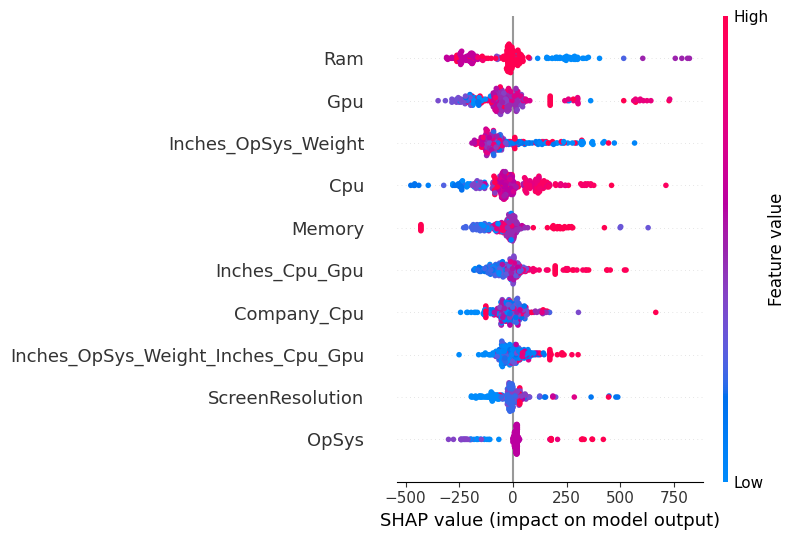

In [16]:
encoded_data = improve_data.copy()

# Select all numeric features (after encoding)
numeric_features = encoded_data.select_dtypes(include=[np.number])

# Calculate SHAP values
explainer = shap.Explainer(best_model, X_train_improve)
shap_values = explainer(X_test_improve)

# Summary plot
shap.summary_plot(shap_values, X_test_improve)

#### Insights

#### B. permutation importance

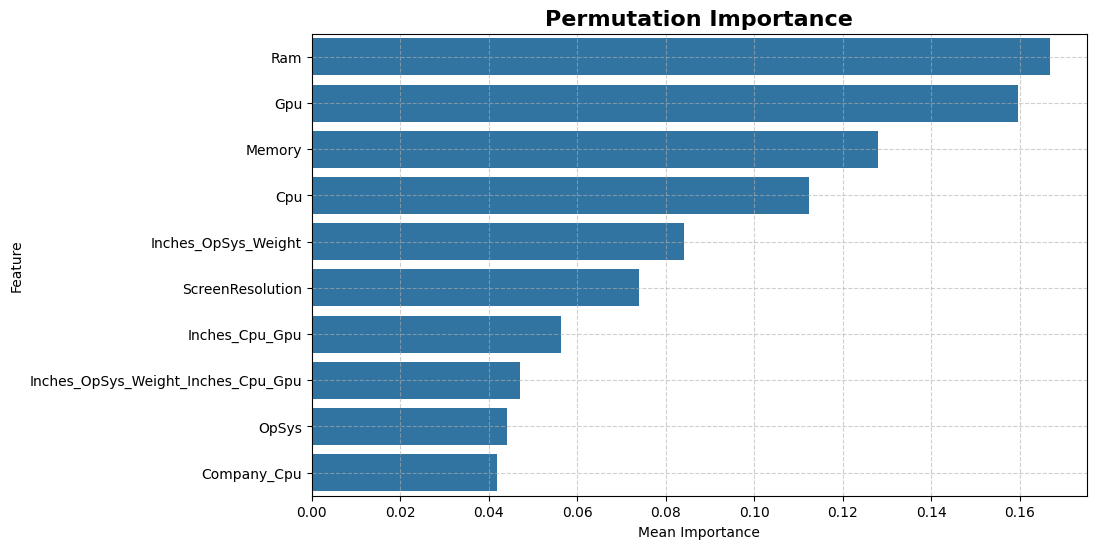

In [17]:
from sklearn.inspection import permutation_importance

# Permutation importance
perm_importance = permutation_importance(best_model, X_test_improve, y_test_improve, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_df = pd.DataFrame({
    'Feature': X_test_improve.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title("Permutation Importance", fontsize=16, fontweight='bold')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Insights

#### C. XGB importance metrics

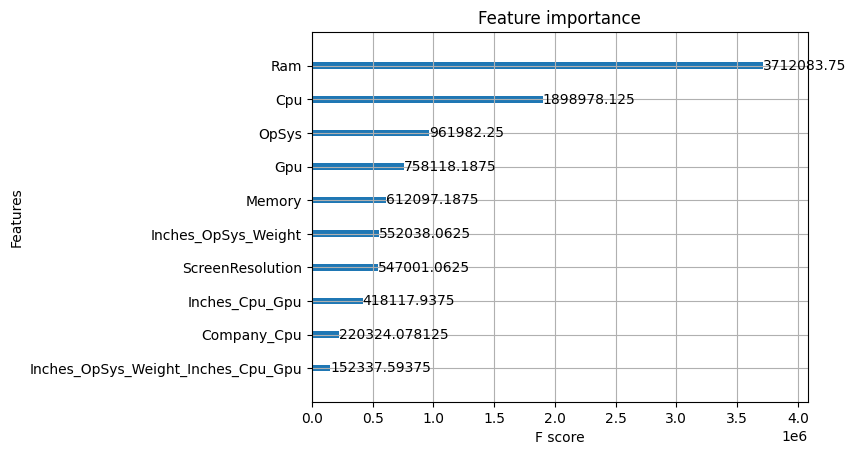

In [18]:
# Feature importance from XGBoost
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.show()

#### Insights

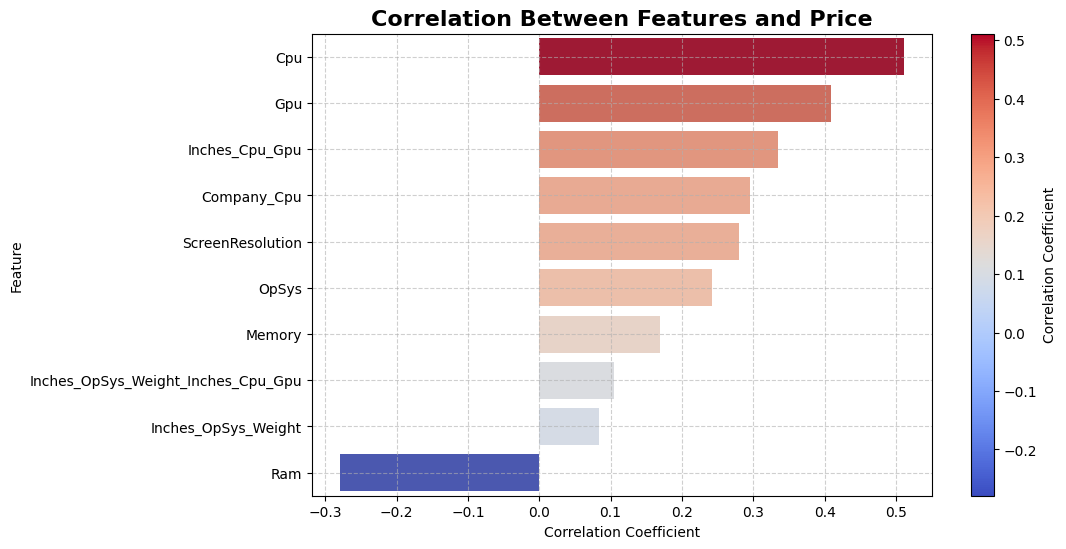

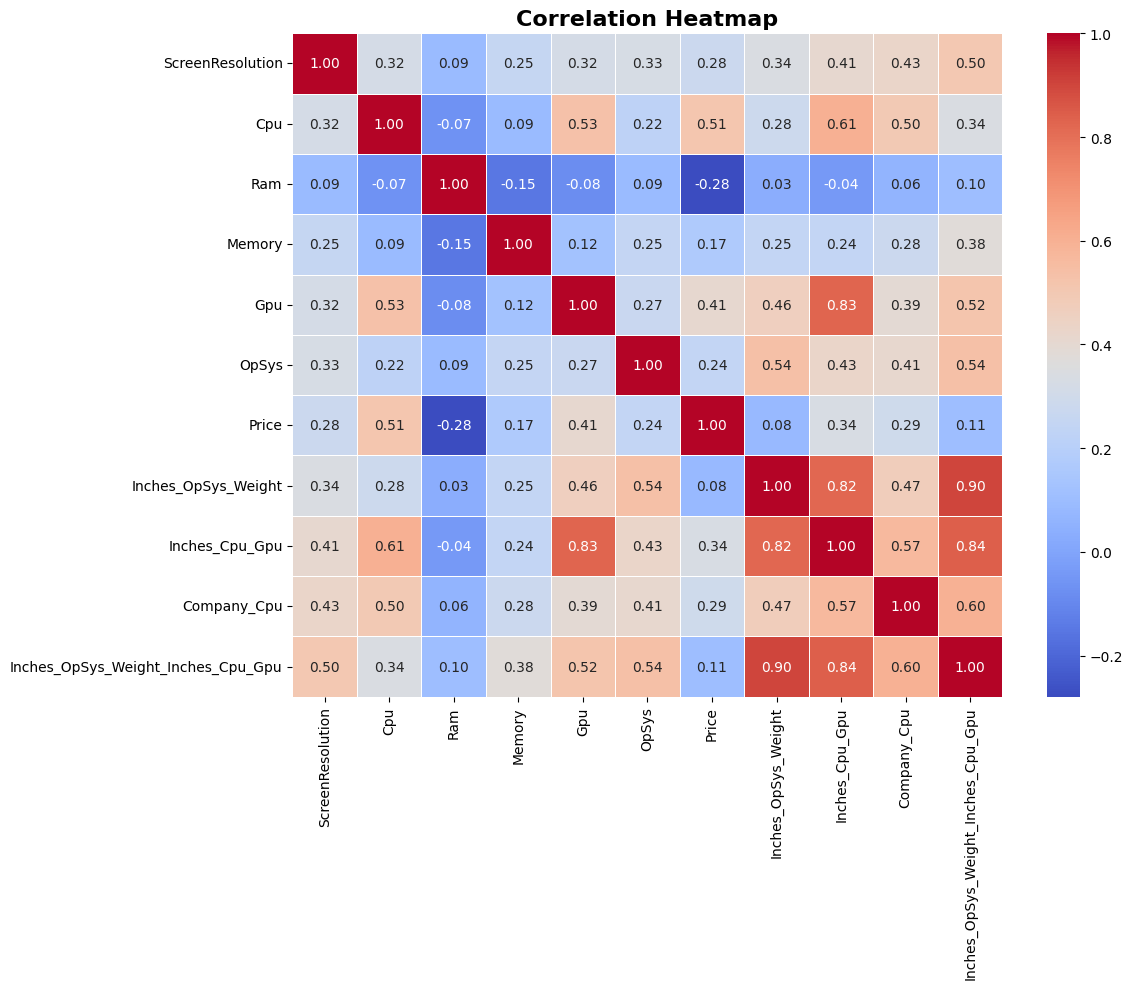

In [19]:
# Correlation matrix
correlation_matrix = improve_data.corr()

# Correlation with the target variable
target_corr = correlation_matrix['Price'].drop('Price').sort_values(ascending=False)

# Normalize the correlation values for color mapping
norm = plt.Normalize(target_corr.min(), target_corr.max())

# Create a color palette based on the normalized values
colors = plt.cm.coolwarm(norm(target_corr.values))

# Plot correlation with heatmap colors
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
plt.title("Correlation Between Features and Price", fontsize=16, fontweight='bold')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Correlation Coefficient')



# Plot the Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 

## Explain Model Performance

#### Comparing RMSE, MAE, R2, Pearson correlation, EVS. 

In [20]:
# Baseline model metrics
baseline_rmse = 313.30
baseline_mae = 193.69
baseline_r2 = 0.845

print("Comparison of Model Performance Metrics:\n")
print(f"Baseline RMSE: {baseline_rmse:.2f} -> Improved Model RMSE: {rmse_improve:.2f}\n")
print(f"Baseline MAE: {baseline_mae:.2f} -> Improved Model MAE: {mae_improve:.2f}\n")
print(f"Baseline R2 Score: {baseline_r2:.3f} -> Improved Model R2 Score: {r2_improve:.3f}\n")


# Calculate Pearson correlation between actual and predicted
from scipy.stats import pearsonr

# Calculate Pearson correlation for the old model
y_pred_old = y_pred
residuals_old = y_test - y_pred_old
pearson_corr_old, _ = pearsonr(y_test, y_pred_old)

# Calculate Pearson correlation for the new model
residuals_improve = y_test_improve - y_pred_improve
pearson_corr_improve, _ = pearsonr(y_test_improve, y_pred_improve)
print(f"Baseline Pearson Correlation: {pearson_corr_old:.3f} -> Improved Model Pearson Correlation: {pearson_corr_improve:.3f}\n")

# Calculate Explained Variance Score
from sklearn.metrics import explained_variance_score

evs_baseline = explained_variance_score(y_test, y_pred_old)
evs_improve = explained_variance_score(y_test_improve, y_pred_improve)
print(f"Baseline EVS: {evs_baseline:.3f} -> Improved Model EVS: {evs_improve:.3f}")


Comparison of Model Performance Metrics:

Baseline RMSE: 313.30 -> Improved Model RMSE: 252.08

Baseline MAE: 193.69 -> Improved Model MAE: 172.49

Baseline R2 Score: 0.845 -> Improved Model R2 Score: 0.898

Baseline Pearson Correlation: 0.920 -> Improved Model Pearson Correlation: 0.948

Baseline EVS: 0.846 -> Improved Model EVS: 0.899


#### Insights

## Visualization

#### A. Residual distributions plot

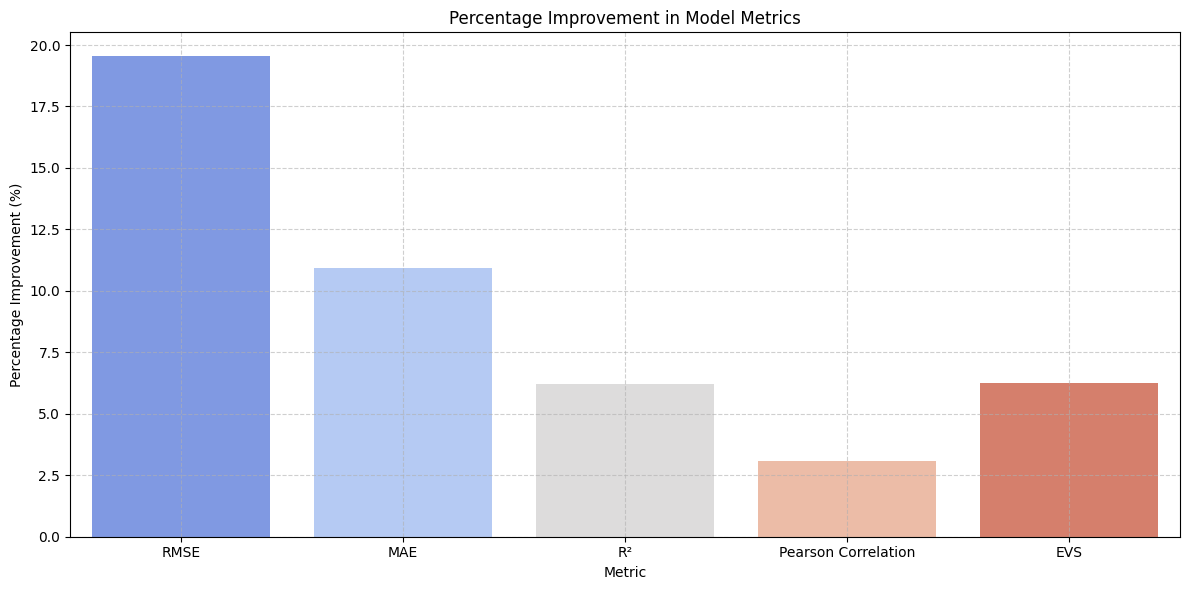

In [28]:
# Calculate percentage improvement
rmse_improvement = ((baseline_rmse - rmse_improve) / baseline_rmse) * 100
mae_improvement = ((baseline_mae - mae_improve) / baseline_mae) * 100
r2_improvement = ((r2_improve - baseline_r2) / baseline_r2) * 100
pearson_improvement = ((pearson_corr_improve - pearson_corr_old) / pearson_corr_old) * 100
evs_improvement = ((evs_improve - evs_baseline) / evs_baseline) * 100

# Define metrics and their improvements
metrics = ['RMSE', 'MAE', 'R²', 'Pearson Correlation', 'EVS']
improvements = [rmse_improvement, mae_improvement, r2_improvement, pearson_improvement, evs_improvement]

# Plot percentage improvement
plt.figure(figsize=(12, 6))
sns.barplot(x=metrics, y=improvements, palette='coolwarm')
plt.title("Percentage Improvement in Model Metrics")
plt.xlabel("Metric")
plt.ylabel("Percentage Improvement (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Insights

#### B. Scatter Plots (Predicted vs. Actual Values)

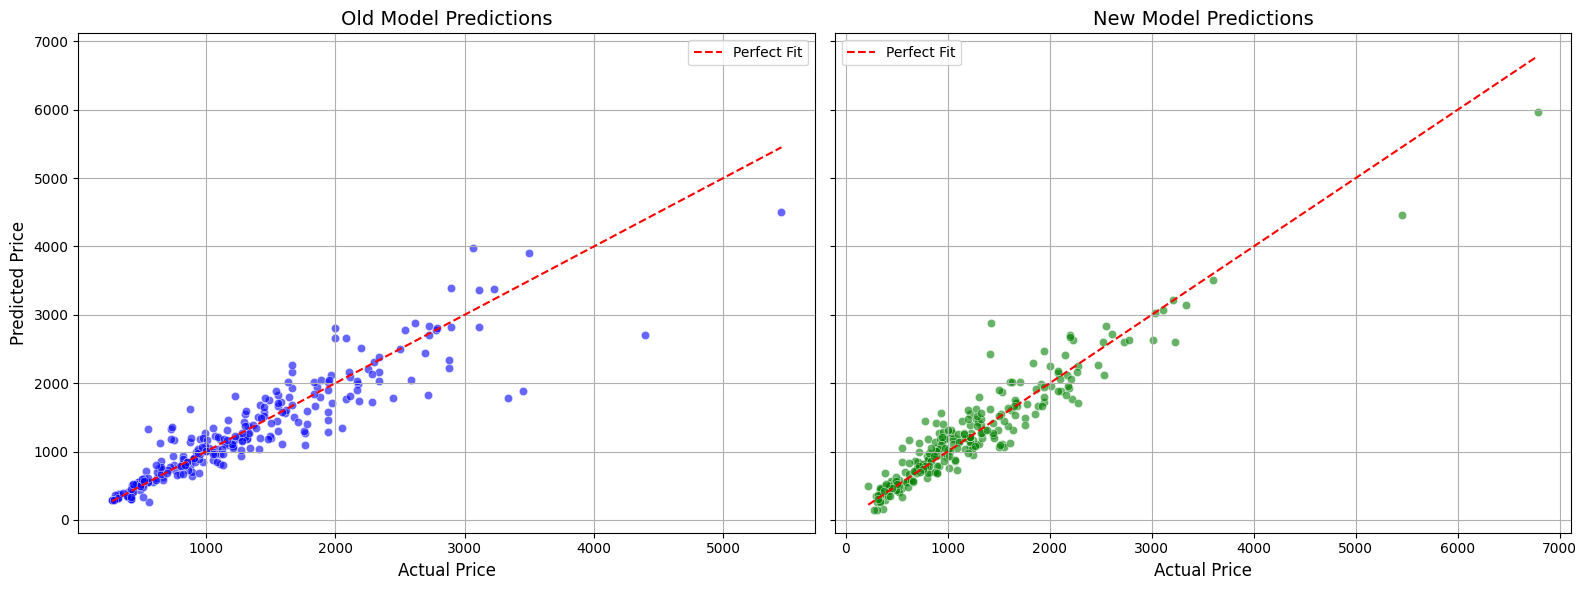

In [29]:
# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for the old model
sns.scatterplot(x=y_test, y=y_pred_old, alpha=0.6, ax=axes[0], color="blue")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
axes[0].set_title("Old Model Predictions", fontsize=14)
axes[0].set_xlabel("Actual Price", fontsize=12)
axes[0].set_ylabel("Predicted Price", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot for the new model
sns.scatterplot(x=y_test_improve, y=y_pred_improve, alpha=0.6, ax=axes[1], color="green")
axes[1].plot([y_test_improve.min(), y_test_improve.max()], [y_test_improve.min(), y_test_improve.max()], 'r--', label='Perfect Fit')
axes[1].set_title("New Model Predictions", fontsize=14)
axes[1].set_xlabel("Actual Price", fontsize=12)
axes[1].set_ylabel("Predicted Price", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Insights

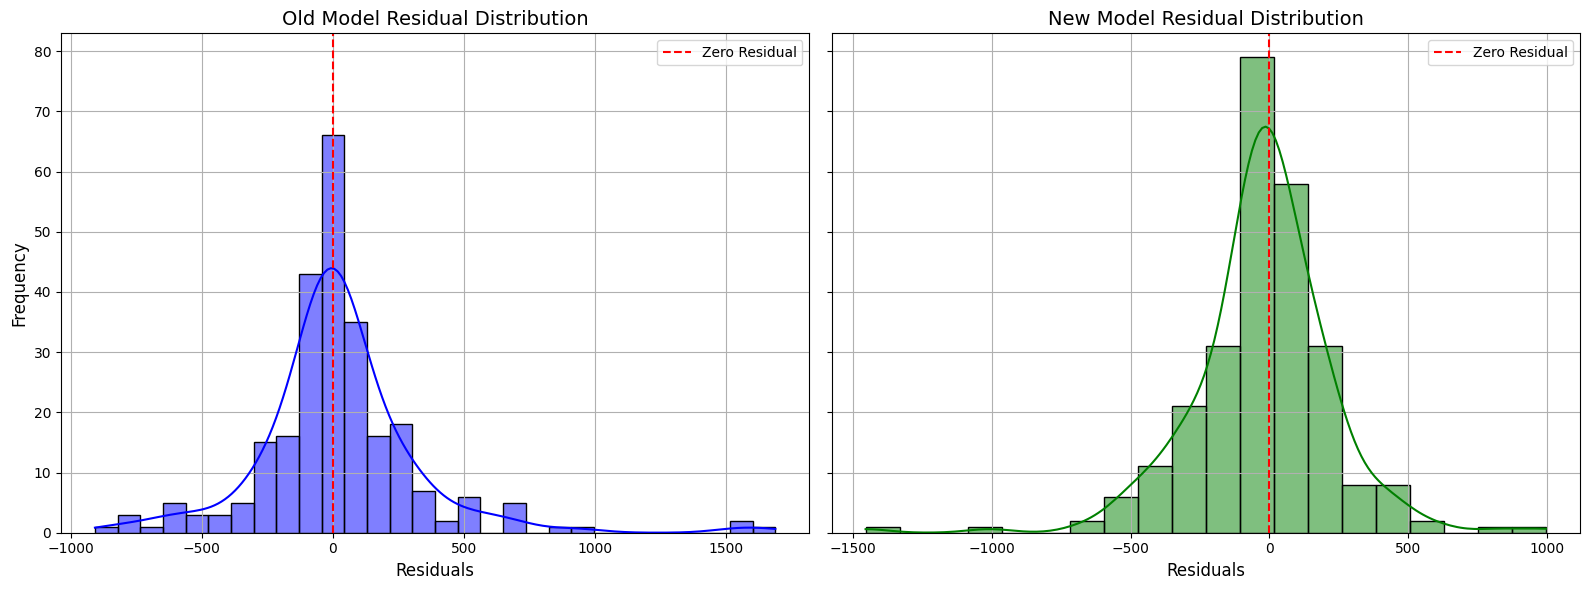

In [30]:
# Create side-by-side plots for residual distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot residuals for the old model
sns.histplot(residuals_old, kde=True, bins=30, color='blue', ax=axes[0])
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[0].set_title("Old Model Residual Distribution", fontsize=14)
axes[0].set_xlabel("Residuals", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot residuals for the new model
sns.histplot(residuals_improve, kde=True, bins=20, color='green', ax=axes[1])
axes[1].axvline(x=0, color='red', linestyle='--', label='Zero Residual')
axes[1].set_title("New Model Residual Distribution", fontsize=14)
axes[1].set_xlabel("Residuals", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Insights

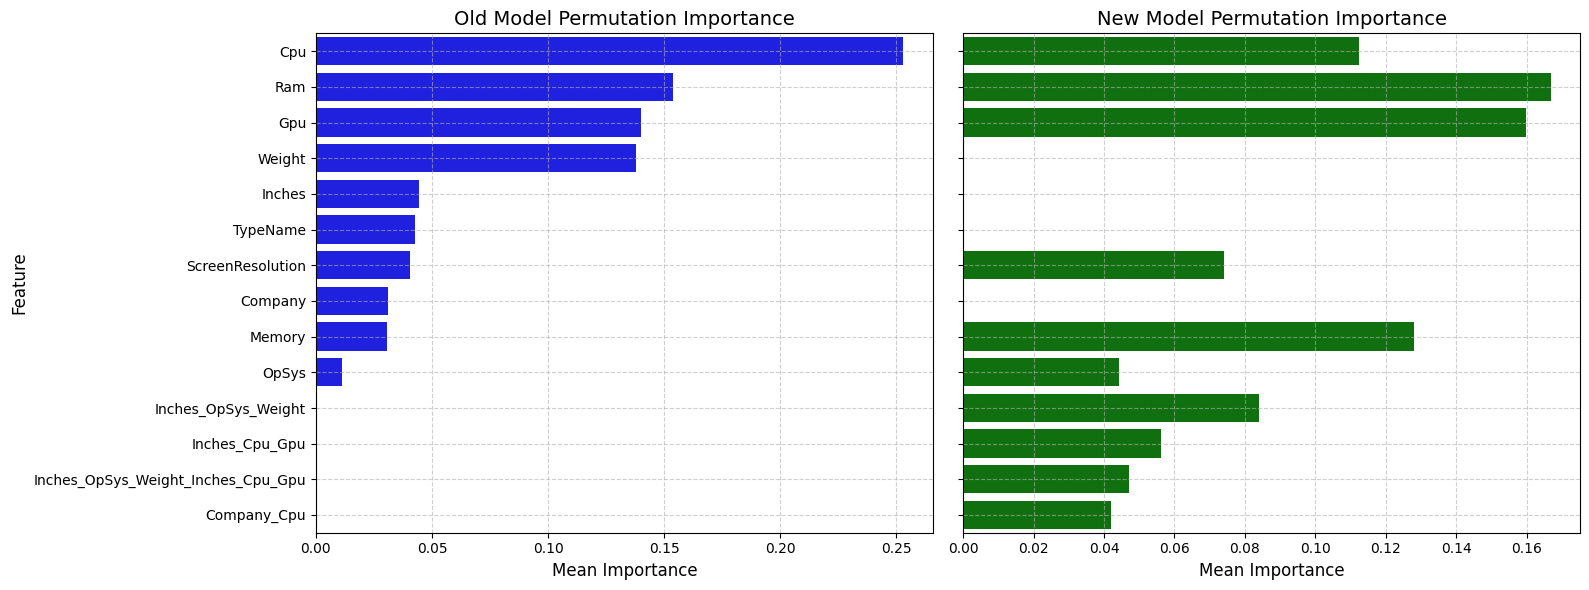

In [31]:
# Permutation importance
perm_importance_old = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importance
perm_df_old = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_old.importances_mean
}).sort_values(by='Importance', ascending=False)


# Create permutation importance plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Old model
sns.barplot(x=perm_df_old['Importance'], y=perm_df_old['Feature'], ax=axes[0], color='blue')
axes[0].set_title("Old Model Permutation Importance", fontsize=14)
axes[0].set_xlabel("Mean Importance", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Improved model
sns.barplot(x=perm_df['Importance'], y=perm_df['Feature'], ax=axes[1], color='green')
axes[1].set_title("New Model Permutation Importance", fontsize=14)
axes[1].set_xlabel("Mean Importance", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


#### Insights

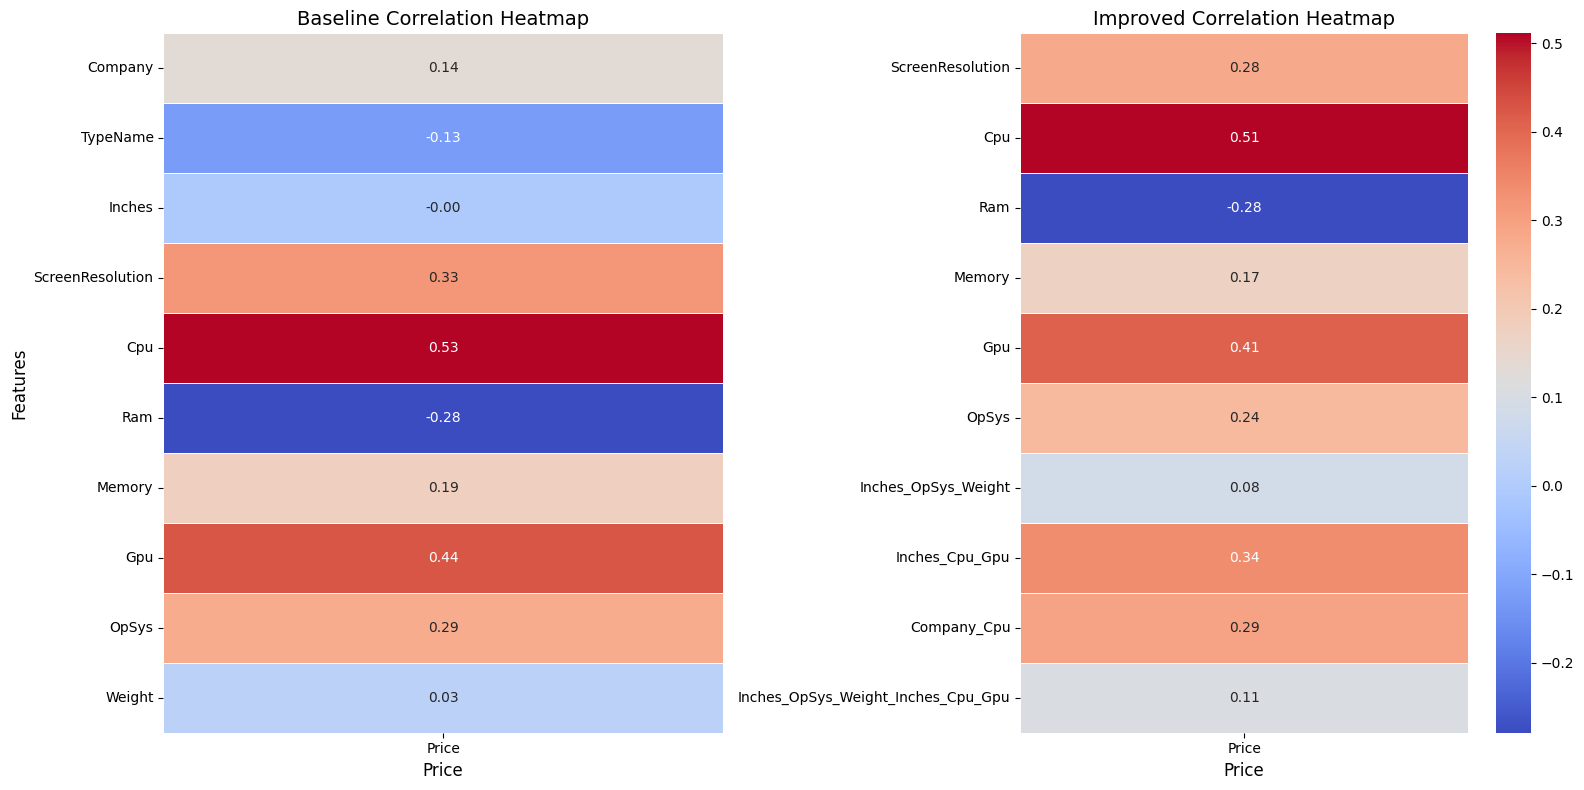

In [33]:
categorical_features = ['Company', 'TypeName', 'OpSys' , 'Gpu', 'Memory', 'Ram', 'Cpu', 'ScreenResolution', 'Inches', 'Weight']
encoder = LabelEncoder()
encoded_data = copy_data.copy()

for feature in categorical_features:
    encoded_data[feature] = encoder.fit_transform(encoded_data[feature])

# Remove the 'ID' column
encoded_data = encoded_data.drop(columns=['ID'])

# Select all numeric features (after encoding)
numeric_features = encoded_data.select_dtypes(include=[np.number])

# Calculate correlation matrices
baseline_corr = numeric_features.corr()
improved_corr = improve_data.corr()

# Filter only correlations with the target variable (Price)
baseline_corr_target = baseline_corr[['Price']].drop('Price')
improved_corr_target = improved_corr[['Price']].drop('Price')

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Baseline correlation heatmap
sns.heatmap(
    baseline_corr_target, annot=True, cmap='coolwarm', fmt=".2f",
    linewidths=0.5, ax=axes[0], cbar=False
)
axes[0].set_title("Baseline Correlation Heatmap", fontsize=14)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Features", fontsize=12)

# Improved correlation heatmap
sns.heatmap(
    improved_corr_target, annot=True, cmap='coolwarm', fmt=".2f",
    linewidths=0.5, ax=axes[1], cbar=True
)
axes[1].set_title("Improved Correlation Heatmap", fontsize=14)
axes[1].set_xlabel("Price", fontsize=12)
axes[1].set_ylabel("")

# Adjust layout and show
plt.tight_layout()
plt.show()


#### insights

## Drawing Conclusions About the Data & Creative Applications